<center><h1> KPMG Machine Learning Modelling Part <center><h1>

## Load Libraries for Cleaning and Modelling

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Imputing

from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modelling Preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold


from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline, FeatureUnion

#from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder


from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

from sklearn.feature_selection import SelectKBest

# Supervised
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              BaggingClassifier)

import xgboost as xgb
from xgboost import XGBClassifier

import shap
shap.initjs()

# Metrics 
from sklearn.metrics import *

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
#df = pd.read_excel('../../../Features_tagging_v4-2nd_tagged-fixed.xlsx', sheet_name = 'features_v7', header = 1)
#df = pd.read_excel('./Features_tagging_v4-2nd_tagged-fixed.xlsx', sheet_name = 'features_v7', header = 1)
#df = pd.read_excel('./Features_tagging_v5_one-line-tagged.xlsx', sheet_name = 'features_v7', header = 1)

df = pd.read_excel('./Features_tagging_v6_one-line-tagged.xlsx', sheet_name = 'features_v7', header = 1)

In [3]:
df.shape

(41910, 35)

#### Missing data analysis

* `line_height` is completely missing 
* `LS` has some missing values: This means that these lines do not have any LS; hence, we'll encode these to 0. 
* The rest of the missing columns are those that we made ourselves to tag the feature. We will be dropping them. 

In [4]:
df.isna().sum() 

text                         0
document                     0
Name                     28755
new_10_doc               39099
Section_Id_Document      41013
Section_ID               41011
Paragraph                40676
Comment                  39719
Class                    31356
df_idx                       0
class                        0
style                        0
id                           0
font-size                    0
vertical-align               0
color                        0
font-family                  0
font-weight                  0
font-style                   0
position                     0
left                         0
top                          0
document_id                  0
page                         0
line-height              41906
Num_Words                    0
String_Length                0
Leading_Char_Upper           0
Leading_Numeral              0
Ends_In_Period               0
Leading_Number_Period        0
Leading_Char_Period          0
Roman_Pe

#### Get document count

In [5]:
num_docs = len(df.groupby('document').count()['text'].rename('Count'))
num_docs

119

#### Drop rows which are not labelled

In [6]:
df = df[df['Class'].isna()==False]

#### See how many documents are done and percentage

In [7]:
num_docs_done = len(df.groupby('document').count()['text'].rename('Count'))

In [8]:
num_docs_done / num_docs

0.3445378151260504

### Extract `first 3 words`,` 5 words`, `first word`, `last word`

In [9]:
df.sample(5)

,text,document,Name,new_10_doc,Section_Id_Document,Section_ID,Paragraph,Comment,Class,df_idx,...,Num_Words,String_Length,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,Left_Px,LS
36287,72 U.S. CONST. amend. V.,html_files/CMS_2014_0115_58260.pdf,Minsu,1.0,NaN,NaN,NaN,footnote,0.0,28999,...,5,24,0,1,1,0,0,1,72,85.0
36069,"and Bryn Austin, Sexual orientation difference...",html_files/CMS_2014_0115_58260.pdf,Minsu,1.0,NaN,NaN,NaN,footnote,0.0,29152,...,14,100,0,0,0,0,0,0,72,14.0
36183,"unlawful and set aside agency action, findings...",html_files/CMS_2014_0115_58260.pdf,Minsu,1.0,NaN,NaN,NaN,NaN,0.0,29100,...,15,81,0,0,1,0,0,0,72,16.0
5674,"cases, a shared identity is more difficult to ...",html_files/CMS_2014_0115_13182.pdf,Liliana,NaN,NaN,NaN,NaN,NaN,0.0,5991,...,17,108,0,0,0,0,0,0,72,14.0
6250,"without English proficiency, materials and ass...",html_files/CMS_2014_0115_13205.pdf,Liliana,NaN,NaN,NaN,NaN,NaN,0.0,32299,...,10,77,0,0,0,0,0,0,108,14.0


In [10]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

In [11]:
### Convert the text column data type to string

import re

df['text'] = df['text'].apply(str)

### Three gram

df['3_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 3))
#df['new_col'] = df.triigrams.apply(lambda x: x[0:1])
df['first_3_words'] = df["3_grams"].str[0]
df['first_3_words'] = df['first_3_words'].apply(str)
df['first_3_words'] = df['first_3_words'].str.replace(r'[^\w\s]+', '')

### Remove stop words from first 3 wodrds

# df['first_3_words'] = df['first_3_words'].apply(lambda x: [item for item in x.split(" ") if item not in stopwords])


### Five gram

df['5_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 5))
df['first_5_words'] = df['5_grams'].str[0]
df['first_5_words'] = df['first_5_words'].apply(str)
df['first_5_words'] = df['first_5_words'].str.replace(r'[^\w\s]+', '')


### I will drop 3-gram and 5_gram columns and keep only fist three words and first five words columns

df = df.drop(['3_grams', '5_grams'], axis = 1)


In [12]:
### Extract first and last word

df["First_Word"] = df["text"].apply(lambda x: x.split()[0:1])
df["First_Word"] = df["First_Word"].apply(str)
df["First_Word"] = df["First_Word"].str.replace(r'[^\w\s]+', '')

df["Last_Word"] = df["text"].apply(lambda x: x.split()[-1:])
df["Last_Word"] = df["Last_Word"].apply(str)
df["Last_Word"] = df["Last_Word"].str.replace(r'[^\w\s]+', '')

In [13]:
# NLP features
import string

df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [14]:
df.sample(2)

,text,document,Name,new_10_doc,Section_Id_Document,Section_ID,Paragraph,Comment,Class,df_idx,...,Roman_Period,Left_Px,LS,first_3_words,first_5_words,First_Word,Last_Word,punctuation_count,title_word_count,upper_case_word_count
38249,"Austin, Sexual orientation differences in teen...",html_files/CMS_2014_0115_58424.pdf,Minsu,NaN,NaN,NaN,NaN,footnote,0.0,6597,...,0,72,13.0,Austin Sexual orientation,Austin Sexual orientation differences in,Austin,2,2,3,0
40726,Potential to Reduce Access to Contraception,html_files/CMS_2014_0115_58448.pdf,Minsu,NaN,NaN,NaN,NaN,NaN,0.0,24167,...,0,125,16.0,Potential to Reduce,Potential to Reduce Access to,Potential,Contraception,0,4,0


In [15]:
df['ratio_of_title_word_to_total'] = pd.to_numeric(df['title_word_count'], downcast='float')/df['Num_Words']
df['ratio_of_title_word_to_total'] = pd.to_numeric(df['title_word_count'], downcast='float')/df['Num_Words']

In [16]:
# Make more features
df['Re'] = df['text'].str.contains('Re:')*1 + df['text'].str.contains('RE:')*1

# Association rule 
df['pred_by_re'] = np.logical_and(df.Re == 1, df.page == 'page1.html')*1

In [17]:
df.to_csv('../../../featuresV9.csv')

## reading selected columns for screen shot

## Separate Test Set 

In [18]:
df_test = df[df['new_10_doc']==1]

In [19]:
df = df[df['new_10_doc'].isna()] # filter all missing 
df.drop(['new_10_doc'], axis=1, inplace=True) # drop column

## Data Cleaning

1. Drop irrelavant columns
2. Convert columns kept to right types 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 44 columns):
text                            7743 non-null object
document                        7743 non-null object
Name                            7743 non-null object
Section_Id_Document             897 non-null float64
Section_ID                      899 non-null float64
Paragraph                       1234 non-null object
Comment                         1165 non-null object
Class                           7743 non-null float64
df_idx                          7743 non-null int64
class                           7743 non-null object
style                           7743 non-null object
id                              7743 non-null object
font-size                       7743 non-null object
vertical-align                  7743 non-null object
color                           7743 non-null object
font-family                     7743 non-null object
font-weight                     7743 non-nul

### 1. Drop Irrelavant Columns 
* Drop text since we don't really need it and are using derived features from it 
* Drop columns that we created ourselves for tagging:
`Name`, `section Id document`, `document id`, `section id`, `Comment`, `Paragraph` are not useful since we created them for labelling or target
* `df_idx` is the same thing as document_id and document 
* We keep `document` : we will cat encdode it later 
* Remove `class` (lowercase) since it only has one value
* Drop `position` since it only has one value
* `line height` has nothing in it ... only **nans** 
* Remove `string length` since it's correlated with numwords
* Remove `Left_Px` since it's the same thing as `left` which I clean in the next section
* Remove `style` since it's the same thing as `font+vertical+align+color` which I clean in the next section
* Remove `vertical-align` since it's the same value which is `baseline`

In [21]:
df = df.drop(['text', 'Name', 'Section_Id_Document', 'document_id',
             'Section_ID', 'Comment', 'Paragraph', 'df_idx' , 'class', 'position',
              'page', 'line-height', 'String_Length', 'Left_Px','style','vertical-align'], axis = 1)

Columns that I may remove later:
- `page`: Not sure if it's relevant at all
- `color`: Need to clean it but may not give any feature importance


### 2. Clean columns:  `font_weight`,`font_style`,`fontsize`, `left` and `top`: 

- Change font_weight and font_size to binary
- Remove px and 
- Convert to right data typ

In [22]:
df['font-weight'] = df['font-weight'].map({'bold': 1, 'normal': 0})
df['font-style'] = df['font-style'].map({'italic': 1, 'normal': 0})

df['font-size'] = df['font-size'].str.replace('px', '')
df['font-size'] = pd.to_numeric(df['font-size'])

df['left'] = df['left'].str.replace('px', '')
df['left'] = pd.to_numeric(df['left'])

df['top'] = df['top'].str.replace('px', '')
df['top'] = pd.to_numeric(df['top'])

#### Chage the data type from `int` to `float`

In [23]:
# 'Start_conclusion','Start_Re','Start_Attention'

cols = ['font-weight', 'font-style', 'left', 'top','Num_Words','Leading_Char_Upper','Leading_Numeral','Ends_In_Period','Leading_Number_Period','Leading_Char_Period','Roman_Period']
for col in cols:
    df[col] = df[col].apply(lambda x: float(x))

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 28 columns):
document                        7743 non-null object
Class                           7743 non-null float64
id                              7743 non-null object
font-size                       7743 non-null int64
color                           7743 non-null object
font-family                     7743 non-null object
font-weight                     7743 non-null float64
font-style                      7743 non-null float64
left                            7743 non-null float64
top                             7743 non-null float64
Num_Words                       7743 non-null float64
Leading_Char_Upper              7743 non-null float64
Leading_Numeral                 7743 non-null float64
Ends_In_Period                  7743 non-null float64
Leading_Number_Period           7743 non-null float64
Leading_Char_Period             7743 non-null float64
Roman_Period                    77

In [25]:
df.to_csv('../../../featuresV10.csv')

#### Impute Missing Column: LS


In [26]:
df['LS'] = df['LS'].fillna(0)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 28 columns):
document                        7743 non-null object
Class                           7743 non-null float64
id                              7743 non-null object
font-size                       7743 non-null int64
color                           7743 non-null object
font-family                     7743 non-null object
font-weight                     7743 non-null float64
font-style                      7743 non-null float64
left                            7743 non-null float64
top                             7743 non-null float64
Num_Words                       7743 non-null float64
Leading_Char_Upper              7743 non-null float64
Leading_Numeral                 7743 non-null float64
Ends_In_Period                  7743 non-null float64
Leading_Number_Period           7743 non-null float64
Leading_Char_Period             7743 non-null float64
Roman_Period                    77

## Modelling
#### Part I: Data Cleaning and Preparation
1. Separate Target and Data
2. Split into Test and Train
3. Clean Numeric Features 
4. Clean Categorical Features
4. Try NLP Techniques
6. Combine Data Frames

#### Part II: Models
1. Logistic Regression
2. Random Forest
4. Playing with Evaluation Metrics
5. Boosting: AdaBoost and Gradient Boosting
6. Boosting: XGBoost

#### Part III: Pipeline and Tune
1. Parameter Tuning on the Best Model with Pipeline 
2. Change Thresholds
3. Evaluate on Test Set

### Part 1: Prepare

#### 1. Separate Target and Features 

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 28 columns):
document                        7743 non-null object
Class                           7743 non-null float64
id                              7743 non-null object
font-size                       7743 non-null int64
color                           7743 non-null object
font-family                     7743 non-null object
font-weight                     7743 non-null float64
font-style                      7743 non-null float64
left                            7743 non-null float64
top                             7743 non-null float64
Num_Words                       7743 non-null float64
Leading_Char_Upper              7743 non-null float64
Leading_Numeral                 7743 non-null float64
Ends_In_Period                  7743 non-null float64
Leading_Number_Period           7743 non-null float64
Leading_Char_Period             7743 non-null float64
Roman_Period                    77

In [29]:
df.shape

(7743, 28)

In [30]:
# Insert RE: into y for a moment

X = df.drop(['Class', 'pred_by_re'], axis = 1)
y = df[['Class', 'pred_by_re']]

# After we do the train-test spliting,
# 30% will be selected for testing data randomly
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

In [31]:
# We make pre_by_re_test, and get y_test & y_train back properly
pred_by_re_train = y_train['pred_by_re']
pred_by_re_test = y_test['pred_by_re']
y_test = y_test['Class']
y_train = y_train['Class']   

In [32]:
X_train.shape

(5420, 26)

#### Check out imbalance

In [33]:
imbalance = (len(y_train[y_train == 1]) / len(y_train)) * 100
print('Class Imblance: {:.2f}%'.format(imbalance))

Class Imblance: 2.08%


0.0    5307
1.0     113
Name: Class, dtype: int64

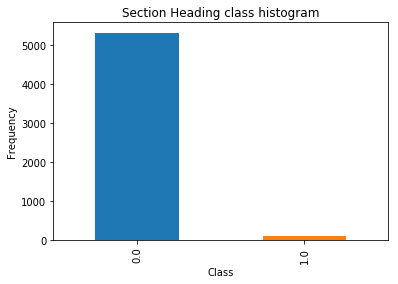

In [34]:
pd.value_counts(y_train).plot.bar()
plt.title('Section Heading class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
y_train.value_counts()

## Part III: Pipeline and Tune
* For this stage, we will use the best model

### Parameter Tuning on the Best Models with Pipeline

#### 1.1 Create the Preprocessing Pipeline

#### Categorical Features

In [35]:
cat_features = list(X.select_dtypes(include="object"))
cat_features.remove('First_Word')
cat_features.remove('Last_Word')
cat_features.remove('first_3_words')
cat_features.remove('first_5_words')
cat_features = cat_features

In [36]:
cat_features

['document', 'id', 'color', 'font-family']

#### Text Features

In [37]:
text_features = list(X.select_dtypes(include="object"))
text_features.remove('document')
text_features.remove('color')
text_features.remove('font-family')
text_features.remove('id')
text_features = text_features

In [38]:
text_features

['first_3_words', 'first_5_words', 'First_Word', 'Last_Word']

In [39]:
first_1 = [text_features[2], text_features[-1]]
first_3 = [text_features[0], text_features[-1]]
first_5 = [text_features[1], text_features[-1]]

In [40]:
first_3_only = text_features[0]
first_1_only = text_features[2]
first_5_only = text_features[1]
last_1_only =  text_features[-1]

#### Numeric Features: We can just borrow from the separations I had made above

In [41]:
list(X.select_dtypes(exclude="object"))

['font-size',
 'font-weight',
 'font-style',
 'left',
 'top',
 'Num_Words',
 'Leading_Char_Upper',
 'Leading_Numeral',
 'Ends_In_Period',
 'Leading_Number_Period',
 'Leading_Char_Period',
 'Roman_Period',
 'LS',
 'punctuation_count',
 'title_word_count',
 'upper_case_word_count',
 'ratio_of_title_word_to_total',
 'Re']

In [42]:
binary_features = ['font-weight', 'font-style', 'Leading_Char_Upper',
                'Leading_Numeral', 'Ends_In_Period', 'Leading_Number_Period',
                'Leading_Char_Period', 'Roman_Period']

In [43]:
continuous_features = ['font-size', 'left', 'top', 'Num_Words', 'LS', 
                       'punctuation_count', 'title_word_count', 'upper_case_word_count', 
                       'ratio_of_title_word_to_total']

#### Chain up Transformations or Custom Transformer

In [44]:
from sklearn.decomposition import PCA

continuous_transformer = Pipeline(steps=[('scale', StandardScaler())]) 

binary_transformer = Pipeline(steps=[('select', SelectKBest(k=len(binary_features)))])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

text_transformer_first = Pipeline([('count_vect_first', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
                             ('tfidf_first', TfidfTransformer())
                             ])

text_transformer_last = Pipeline([('count_vect_last', CountVectorizer()), 
                             ('tfidf_last', TfidfTransformer())
                             ])

In [45]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, continuous_features),
        ('binary', binary_transformer, binary_features),
        ('cat', categorical_transformer,cat_features),
        ('text_first', text_transformer_first, first_3_only),
        ('text_last', text_transformer_last, last_1_only)])

In [46]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [47]:
sm = SMOTE(random_state=42)

In [48]:
#final_pipeline_rf = Pipeline([('preprocessor', preprocessor), 
                            #  ('classifier', RandomForestClassifier(class_weight =  'balanced', random_state=4242))])

In [49]:
final_pipeline_rf = Pipeline([('preprocessor', preprocessor), 
                     ('smote', sm),
                     ('classifier', RandomForestClassifier(class_weight =  'balanced', random_state=4242))])

### 1. Random Forst with GridSearch

In [50]:
param_grid = {'classifier__n_estimators':[70, 80, 90, 100],
               'classifier__max_depth':[50,60,70,80,90, None]}

cv = StratifiedKFold(n_splits=5)

In [51]:
grid_rf = GridSearchCV(final_pipeline_rf, param_grid, cv = cv, scoring = 'roc_auc')

grid_rf.fit(X_train, y_train)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with inp

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with inp

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with inp

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cont', Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['font-size', 'left', 'top', 'Num...='warn', n_jobs=None, oob_score=False,
            random_state=4242, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__n_estimators': [70, 80, 90, 100], 'classifier__max_depth': [50, 60, 70, 80, 90, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Evaluation on Train Set 

In [52]:
print("Best Score %s" % grid_rf.best_score_)
print("Best Parameter %s" % grid_rf.best_params_) 

Best Score 0.990849698902994
Best Parameter {'classifier__max_depth': 50, 'classifier__n_estimators': 100}


#### Change Thresholds and Re-evaluate Models

In [53]:
pred_probs = grid_rf.predict_proba(X_train)[:, 1]

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


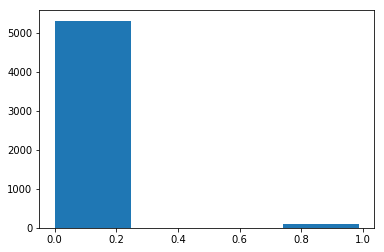

In [54]:
plt.hist(pred_probs, bins=4)
plt.show()

In [55]:
def metrics(y, pred):
    print("Accuracy score: {:.2f}".format(accuracy_score(y, pred)))
    print("F1 score: {:.2f}".format(f1_score(y, pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y, pred)))

In [56]:
def confusion_metrics(y, pred):
    cm = confusion_matrix(y, pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])
    print(" ")
    print("Other Metrics:")
    print(" ")
    print("Precision %.2f" % (cm[1][1] / (cm[1][1] + cm[0][1])))
    print("Recall / True Positive Rate %.2f" % (cm[1][1] / (cm[1][1] + cm[1][0])))   
    print("True Negative Rate: %.2f" % (cm[0][0] / (cm[0][0] + cm[0][1])))   

In [57]:
for i in np.arange(0,0.5,0.05):
    y_pred = grid_rf.predict_proba(X_train)[:, 1] > i
    print("")
    print("Metrics")
    print("")
    print(confusion_metrics(y_train, y_pred))

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 14
False Negatives: 0
True Positives: 113
False Positives: 5293
 
Other Metrics:
 
Precision 0.02
Recall / True Positive Rate 1.00
True Negative Rate: 0.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 4905
False Negatives: 0
True Positives: 113
False Positives: 402
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 1.00
True Negative Rate: 0.92
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5216
False Negatives: 0
True Positives: 113
False Positives: 91
 
Other Metrics:
 
Precision 0.55
Recall / True Positive Rate 1.00
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5288
False Negatives: 0
True Positives: 113
False Positives: 19
 
Other Metrics:
 
Precision 0.86
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5297
False Negatives: 0
True Positives: 113
False Positives: 10
 
Other Metrics:
 
Precision 0.92
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5304
False Negatives: 0
True Positives: 113
False Positives: 3
 
Other Metrics:
 
Precision 0.97
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5306
False Negatives: 0
True Positives: 113
False Positives: 1
 
Other Metrics:
 
Precision 0.99
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5307
False Negatives: 0
True Positives: 113
False Positives: 0
 
Other Metrics:
 
Precision 1.00
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5307
False Negatives: 0
True Positives: 113
False Positives: 0
 
Other Metrics:
 
Precision 1.00
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5307
False Negatives: 0
True Positives: 113
False Positives: 0
 
Other Metrics:
 
Precision 1.00
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None


#### Feature Importances

In [58]:
def plot_top_k_feature_importances_pipe(feature_names, coefs, k): 
    # sort 
    args = abs(coefs).argsort()[::-1][:k]    
    # get coefs 
    top_k_coefs = coefs[args]    
    # get column names
    colnames = feature_names[args]
    # plot 
    plt.barh(range(k), top_k_coefs, align='center') 
    plt.yticks(np.arange(k), colnames) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, k)
    plt.show()

In [59]:
def get_feature_names(grid):
    cont_cols = grid.best_estimator_.named_steps['preprocessor'].transformers_[0][2]
    bin_cols = grid.best_estimator_.named_steps['preprocessor'].transformers_[1][2]
    cat_cols = grid.best_estimator_.named_steps['preprocessor'].transformers_[2][1].named_steps['onehot'].get_feature_names()
    first_word = grid.best_estimator_.named_steps['preprocessor'].transformers_[3][1].named_steps['count_vect_first'].get_feature_names()
    last_word = grid.best_estimator_.named_steps['preprocessor'].transformers_[4][1].named_steps['count_vect_last'].get_feature_names()
    one_hot_feature_names = np.concatenate((cont_cols, bin_cols,cat_cols, first_word, last_word), axis = None)
    return one_hot_feature_names

In [60]:
one_hot_feature_names_rf = get_feature_names(grid_rf)

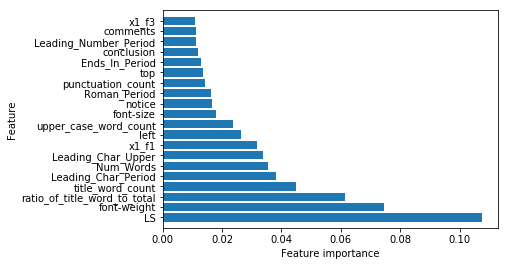

In [61]:
plot_top_k_feature_importances_pipe(one_hot_feature_names_rf, 
                                    grid_rf.best_estimator_.named_steps['classifier'].feature_importances_, 
                                    20)

### Evaluation on Test Set 

In [62]:
grid_rf.score(X_test,y_test)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9965724923346474

#### Other Metrics

In [63]:
y_pred = grid_rf.predict(X_test)

# Merge y_pred with y_pred_with_red
y_pred = y_pred.astype(int) | pred_by_re_test.astype(int)
confusion_metrics(y_test, y_pred)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 2281
False Negatives: 19
True Positives: 21
False Positives: 2
 
Other Metrics:
 
Precision 0.91
Recall / True Positive Rate 0.53
True Negative Rate: 1.00


In [64]:
metrics(y_test, y_pred)

Accuracy score: 0.99
F1 score: 0.67
ROC AUC score: 0.76


In [65]:
confusion_metrics(y_test, y_pred)

True Negatives: 2281
False Negatives: 19
True Positives: 21
False Positives: 2
 
Other Metrics:
 
Precision 0.91
Recall / True Positive Rate 0.53
True Negative Rate: 1.00


#### Change Thresholds and Re-Evaluate

In [66]:
pred_probs = grid_rf.predict_proba(X_test)[:, 1] 

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


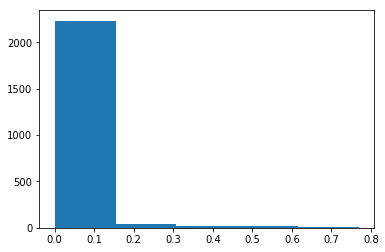

In [67]:
plt.hist(pred_probs, bins=5)
plt.show()

In [68]:
y_pred_probs = grid_rf.predict_proba(X_test)[:, 1]

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [69]:
def plot_pr_curve(y_test, y_pred_probs):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs) 
    thresholds = np.append(thresholds, 1) 
    queue_rate = [] 
    for threshold in thresholds: 
        queue_rate.append((y_pred >= threshold).mean()) 
    plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
    plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
    #plt.plot(thresholds, queue_rate, color=sns.color_palette()[2]) 
    leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True) 
    leg.get_frame().set_edgecolor('k') 
    plt.xlabel('Threshold') 
    plt.ylabel('Score')

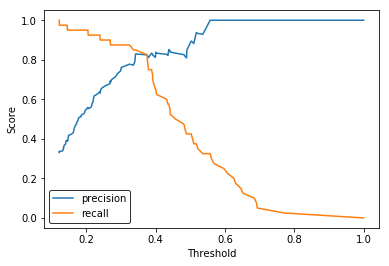

In [70]:
plot_pr_curve(y_test, y_pred_probs)

In [71]:
for i in np.arange(0,0.5,0.01):
    y_pred = grid_rf.predict_proba(X_test)[:, 1] > i
    print("")
    print("Metrics")
    print("Threshold =", i)
    print("")
    print(metrics(y_test, y_pred))
    print(confusion_metrics(y_test, y_pred))

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.0

Accuracy score: 0.02
F1 score: 0.03
ROC AUC score: 0.50
None
True Negatives: 4
False Negatives: 0
True Positives: 40
False Positives: 2279
 
Other Metrics:
 
Precision 0.02
Recall / True Positive Rate 1.00
True Negative Rate: 0.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.01

Accuracy score: 0.50
F1 score: 0.06
ROC AUC score: 0.75
None
True Negatives: 1125
False Negatives: 0
True Positives: 40
False Positives: 1158
 
Other Metrics:
 
Precision 0.03
Recall / True Positive Rate 1.00
True Negative Rate: 0.49
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.02

Accuracy score: 0.67
F1 score: 0.10
ROC AUC score: 0.83
None
True Negatives: 1523
False Negatives: 0
True Positives: 40
False Positives: 760
 
Other Metrics:
 
Precision 0.05
Recall / True Positive Rate 1.00
True Negative Rate: 0.67
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.03

Accuracy score: 0.77
F1 score: 0.13
ROC AUC score: 0.88
None
True Negatives: 1755
False Negatives: 0
True Positives: 40
False Positives: 528
 
Other Metrics:
 
Precision 0.07
Recall / True Positive Rate 1.00
True Negative Rate: 0.77
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.04

Accuracy score: 0.83
F1 score: 0.17
ROC AUC score: 0.91
None
True Negatives: 1883
False Negatives: 0
True Positives: 40
False Positives: 400
 
Other Metrics:
 
Precision 0.09
Recall / True Positive Rate 1.00
True Negative Rate: 0.82
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.05

Accuracy score: 0.86
F1 score: 0.20
ROC AUC score: 0.93
None
True Negatives: 1962
False Negatives: 0
True Positives: 40
False Positives: 321
 
Other Metrics:
 
Precision 0.11
Recall / True Positive Rate 1.00
True Negative Rate: 0.86
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.06

Accuracy score: 0.89
F1 score: 0.23
ROC AUC score: 0.94
None
True Negatives: 2019
False Negatives: 0
True Positives: 40
False Positives: 264
 
Other Metrics:
 
Precision 0.13
Recall / True Positive Rate 1.00
True Negative Rate: 0.88
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.07

Accuracy score: 0.91
F1 score: 0.27
ROC AUC score: 0.95
None
True Negatives: 2070
False Negatives: 0
True Positives: 40
False Positives: 213
 
Other Metrics:
 
Precision 0.16
Recall / True Positive Rate 1.00
True Negative Rate: 0.91
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.08

Accuracy score: 0.92
F1 score: 0.31
ROC AUC score: 0.96
None
True Negatives: 2107
False Negatives: 0
True Positives: 40
False Positives: 176
 
Other Metrics:
 
Precision 0.19
Recall / True Positive Rate 1.00
True Negative Rate: 0.92
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.09

Accuracy score: 0.94
F1 score: 0.35
ROC AUC score: 0.97
None
True Negatives: 2136
False Negatives: 0
True Positives: 40
False Positives: 147
 
Other Metrics:
 
Precision 0.21
Recall / True Positive Rate 1.00
True Negative Rate: 0.94
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.1

Accuracy score: 0.95
F1 score: 0.39
ROC AUC score: 0.97
None
True Negatives: 2160
False Negatives: 0
True Positives: 40
False Positives: 123
 
Other Metrics:
 
Precision 0.25
Recall / True Positive Rate 1.00
True Negative Rate: 0.95
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.11

Accuracy score: 0.96
F1 score: 0.44
ROC AUC score: 0.98
None
True Negatives: 2181
False Negatives: 0
True Positives: 40
False Positives: 102
 
Other Metrics:
 
Precision 0.28
Recall / True Positive Rate 1.00
True Negative Rate: 0.96
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.12

Accuracy score: 0.96
F1 score: 0.48
ROC AUC score: 0.98
None
True Negatives: 2196
False Negatives: 0
True Positives: 40
False Positives: 87
 
Other Metrics:
 
Precision 0.31
Recall / True Positive Rate 1.00
True Negative Rate: 0.96
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.13

Accuracy score: 0.97
F1 score: 0.50
ROC AUC score: 0.97
None
True Negatives: 2207
False Negatives: 1
True Positives: 39
False Positives: 76
 
Other Metrics:
 
Precision 0.34
Recall / True Positive Rate 0.97
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.14

Accuracy score: 0.97
F1 score: 0.54
ROC AUC score: 0.97
None
True Negatives: 2218
False Negatives: 1
True Positives: 39
False Positives: 65
 
Other Metrics:
 
Precision 0.38
Recall / True Positive Rate 0.97
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.15

Accuracy score: 0.98
F1 score: 0.58
ROC AUC score: 0.96
None
True Negatives: 2231
False Negatives: 2
True Positives: 38
False Positives: 52
 
Other Metrics:
 
Precision 0.42
Recall / True Positive Rate 0.95
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.16

Accuracy score: 0.98
F1 score: 0.59
ROC AUC score: 0.96
None
True Negatives: 2233
False Negatives: 2
True Positives: 38
False Positives: 50
 
Other Metrics:
 
Precision 0.43
Recall / True Positive Rate 0.95
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.17

Accuracy score: 0.98
F1 score: 0.63
ROC AUC score: 0.97
None
True Negatives: 2241
False Negatives: 2
True Positives: 38
False Positives: 42
 
Other Metrics:
 
Precision 0.47
Recall / True Positive Rate 0.95
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.18

Accuracy score: 0.98
F1 score: 0.67
ROC AUC score: 0.97
None
True Negatives: 2247
False Negatives: 2
True Positives: 38
False Positives: 36
 
Other Metrics:
 
Precision 0.51
Recall / True Positive Rate 0.95
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.19

Accuracy score: 0.98
F1 score: 0.68
ROC AUC score: 0.97
None
True Negatives: 2249
False Negatives: 2
True Positives: 38
False Positives: 34
 
Other Metrics:
 
Precision 0.53
Recall / True Positive Rate 0.95
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.2

Accuracy score: 0.99
F1 score: 0.70
ROC AUC score: 0.97
None
True Negatives: 2252
False Negatives: 2
True Positives: 38
False Positives: 31
 
Other Metrics:
 
Precision 0.55
Recall / True Positive Rate 0.95
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.21

Accuracy score: 0.99
F1 score: 0.70
ROC AUC score: 0.96
None
True Negatives: 2254
False Negatives: 3
True Positives: 37
False Positives: 29
 
Other Metrics:
 
Precision 0.56
Recall / True Positive Rate 0.93
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.22

Accuracy score: 0.99
F1 score: 0.73
ROC AUC score: 0.96
None
True Negatives: 2259
False Negatives: 3
True Positives: 37
False Positives: 24
 
Other Metrics:
 
Precision 0.61
Recall / True Positive Rate 0.93
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.23

Accuracy score: 0.99
F1 score: 0.75
ROC AUC score: 0.96
None
True Negatives: 2261
False Negatives: 3
True Positives: 37
False Positives: 22
 
Other Metrics:
 
Precision 0.63
Recall / True Positive Rate 0.93
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.24

Accuracy score: 0.99
F1 score: 0.74
ROC AUC score: 0.95
None
True Negatives: 2262
False Negatives: 4
True Positives: 36
False Positives: 21
 
Other Metrics:
 
Precision 0.63
Recall / True Positive Rate 0.90
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.25

Accuracy score: 0.99
F1 score: 0.77
ROC AUC score: 0.95
None
True Negatives: 2265
False Negatives: 4
True Positives: 36
False Positives: 18
 
Other Metrics:
 
Precision 0.67
Recall / True Positive Rate 0.90
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.26

Accuracy score: 0.99
F1 score: 0.77
ROC AUC score: 0.95
None
True Negatives: 2266
False Negatives: 4
True Positives: 36
False Positives: 17
 
Other Metrics:
 
Precision 0.68
Recall / True Positive Rate 0.90
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.27

Accuracy score: 0.99
F1 score: 0.78
ROC AUC score: 0.93
None
True Negatives: 2268
False Negatives: 5
True Positives: 35
False Positives: 15
 
Other Metrics:
 
Precision 0.70
Recall / True Positive Rate 0.88
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.28

Accuracy score: 0.99
F1 score: 0.79
ROC AUC score: 0.93
None
True Negatives: 2269
False Negatives: 5
True Positives: 35
False Positives: 14
 
Other Metrics:
 
Precision 0.71
Recall / True Positive Rate 0.88
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.29

Accuracy score: 0.99
F1 score: 0.80
ROC AUC score: 0.93
None
True Negatives: 2271
False Negatives: 5
True Positives: 35
False Positives: 12
 
Other Metrics:
 
Precision 0.74
Recall / True Positive Rate 0.88
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.3

Accuracy score: 0.99
F1 score: 0.81
ROC AUC score: 0.94
None
True Negatives: 2272
False Negatives: 5
True Positives: 35
False Positives: 11
 
Other Metrics:
 
Precision 0.76
Recall / True Positive Rate 0.88
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.31

Accuracy score: 0.99
F1 score: 0.82
ROC AUC score: 0.94
None
True Negatives: 2273
False Negatives: 5
True Positives: 35
False Positives: 10
 
Other Metrics:
 
Precision 0.78
Recall / True Positive Rate 0.88
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.32

Accuracy score: 0.99
F1 score: 0.82
ROC AUC score: 0.94
None
True Negatives: 2273
False Negatives: 5
True Positives: 35
False Positives: 10
 
Other Metrics:
 
Precision 0.78
Recall / True Positive Rate 0.88
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.33

Accuracy score: 0.99
F1 score: 0.81
ROC AUC score: 0.92
None
True Negatives: 2273
False Negatives: 6
True Positives: 34
False Positives: 10
 
Other Metrics:
 
Precision 0.77
Recall / True Positive Rate 0.85
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.34

Accuracy score: 0.99
F1 score: 0.83
ROC AUC score: 0.92
None
True Negatives: 2275
False Negatives: 6
True Positives: 34
False Positives: 8
 
Other Metrics:
 
Precision 0.81
Recall / True Positive Rate 0.85
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.35000000000000003

Accuracy score: 0.99
F1 score: 0.82
ROC AUC score: 0.91
None
True Negatives: 2276
False Negatives: 7
True Positives: 33
False Positives: 7
 
Other Metrics:
 
Precision 0.82
Recall / True Positive Rate 0.82
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.36

Accuracy score: 0.99
F1 score: 0.82
ROC AUC score: 0.91
None
True Negatives: 2276
False Negatives: 7
True Positives: 33
False Positives: 7
 
Other Metrics:
 
Precision 0.82
Recall / True Positive Rate 0.82
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.37

Accuracy score: 0.99
F1 score: 0.82
ROC AUC score: 0.91
None
True Negatives: 2276
False Negatives: 7
True Positives: 33
False Positives: 7
 
Other Metrics:
 
Precision 0.82
Recall / True Positive Rate 0.82
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.38

Accuracy score: 0.99
F1 score: 0.79
ROC AUC score: 0.87
None
True Negatives: 2277
False Negatives: 10
True Positives: 30
False Positives: 6
 
Other Metrics:
 
Precision 0.83
Recall / True Positive Rate 0.75
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.39

Accuracy score: 0.99
F1 score: 0.77
ROC AUC score: 0.86
None
True Negatives: 2277
False Negatives: 11
True Positives: 29
False Positives: 6
 
Other Metrics:
 
Precision 0.83
Recall / True Positive Rate 0.72
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.4

Accuracy score: 0.99
F1 score: 0.73
ROC AUC score: 0.82
None
True Negatives: 2278
False Negatives: 14
True Positives: 26
False Positives: 5
 
Other Metrics:
 
Precision 0.84
Recall / True Positive Rate 0.65
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.41000000000000003

Accuracy score: 0.99
F1 score: 0.70
ROC AUC score: 0.80
None
True Negatives: 2278
False Negatives: 16
True Positives: 24
False Positives: 5
 
Other Metrics:
 
Precision 0.83
Recall / True Positive Rate 0.60
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.42

Accuracy score: 0.99
F1 score: 0.70
ROC AUC score: 0.80
None
True Negatives: 2278
False Negatives: 16
True Positives: 24
False Positives: 5
 
Other Metrics:
 
Precision 0.83
Recall / True Positive Rate 0.60
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.43

Accuracy score: 0.99
F1 score: 0.70
ROC AUC score: 0.80
None
True Negatives: 2278
False Negatives: 16
True Positives: 24
False Positives: 5
 
Other Metrics:
 
Precision 0.83
Recall / True Positive Rate 0.60
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.44

Accuracy score: 0.99
F1 score: 0.67
ROC AUC score: 0.77
None
True Negatives: 2279
False Negatives: 18
True Positives: 22
False Positives: 4
 
Other Metrics:
 
Precision 0.85
Recall / True Positive Rate 0.55
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.45

Accuracy score: 0.99
F1 score: 0.62
ROC AUC score: 0.75
None
True Negatives: 2279
False Negatives: 20
True Positives: 20
False Positives: 4
 
Other Metrics:
 
Precision 0.83
Recall / True Positive Rate 0.50
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.46

Accuracy score: 0.99
F1 score: 0.60
ROC AUC score: 0.74
None
True Negatives: 2279
False Negatives: 21
True Positives: 19
False Positives: 4
 
Other Metrics:
 
Precision 0.83
Recall / True Positive Rate 0.47
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.47000000000000003

Accuracy score: 0.99
F1 score: 0.60
ROC AUC score: 0.74
None
True Negatives: 2279
False Negatives: 21
True Positives: 19
False Positives: 4
 
Other Metrics:
 
Precision 0.83
Recall / True Positive Rate 0.47
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.48

Accuracy score: 0.99
F1 score: 0.60
ROC AUC score: 0.74
None
True Negatives: 2279
False Negatives: 21
True Positives: 19
False Positives: 4
 
Other Metrics:
 
Precision 0.83
Recall / True Positive Rate 0.47
True Negative Rate: 1.00
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.49

Accuracy score: 0.99
F1 score: 0.57
ROC AUC score: 0.71
None
True Negatives: 2280
False Negatives: 23
True Positives: 17
False Positives: 3
 
Other Metrics:
 
Precision 0.85
Recall / True Positive Rate 0.42
True Negative Rate: 1.00
None


## Final Evaluation: using threshold = 0.2

In [83]:
y_pred = grid_rf.predict_proba(X_test)[:, 1] > 0.31

# Merge y_pred with y_pred_with_red
y_pred = y_pred.astype(int) | pred_by_re_test.astype(int)
confusion_metrics(y_test, y_pred)
metrics(y_test, y_pred)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 2273
False Negatives: 4
True Positives: 36
False Positives: 10
 
Other Metrics:
 
Precision 0.78
Recall / True Positive Rate 0.90
True Negative Rate: 1.00
Accuracy score: 0.99
F1 score: 0.84
ROC AUC score: 0.95


### Spotting Mistakes

In [84]:
def get_mistakes(grid, X, y):
    
    y_pred_probs = pd.DataFrame(grid.predict_proba(X)[:, 1], columns = ['Predicted_Probabilities'])
    
    # Reset indices to concat properly
    X.reset_index(inplace = True)
    
    # make y a pandas dataframe to be able to concat
    y = pd.DataFrame(y)
    
    y.reset_index(inplace = True)
    
    y_pred_probs.reset_index(inplace = True)
    
    # concat all columns
    mistakes = pd.concat([X, y, y_pred_probs], axis=1)
    
    # drop the columns that were created due to reset_index
    mistakes.drop(['index'], axis = 1, inplace = True)
    
    # sort dataframe by predicted probabilities
    
    mistakes.sort_values(by=['Predicted_Probabilities'], inplace=True)
    
    # filter out true 0s
    mistakes = mistakes[mistakes['Class']==1]
    
    return mistakes

In [85]:
mistakes_train = get_mistakes(grid_rf, X_train, y_train)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [86]:
mistakes_train.head()

,level_0,document,id,font-size,color,font-family,font-weight,font-style,left,top,...,first_5_words,First_Word,Last_Word,punctuation_count,title_word_count,upper_case_word_count,ratio_of_title_word_to_total,Re,Class,Predicted_Probabilities
719,719,html_files/CMS_2014_0115_58448.pdf,f4,12,"rgba(0,0,0,1)",sans-serif,0.0,0.0,72.0,614.0,...,The Departments costbenefit analysis,,inadequate,2,2,0,0.285714,0,1.0,0.627073
3452,3452,html_files/CMS_2014_0115_9981.pdf,f2,11,"rgba(0,0,0,1)",serif,0.0,0.0,72.0,167.0,...,nan,Scope,Accommodation,0,2,0,0.500000,0,1.0,0.640115
4476,4476,html_files/CMS_2014_0115_13182.pdf,f1,11,"rgba(0,0,0,1)",sans-serif,0.0,0.0,162.0,262.0,...,Re Coverage of Certain Preventive,Re,Act,2,9,0,0.818182,1,1.0,0.656839
4010,4010,html_files/CMS_2014_0115_12572.pdf,f4,11,"rgba(0,0,0,1)",serif,1.0,0.0,89.0,243.0,...,nan,Attention,CMS9940P,3,1,1,0.500000,0,1.0,0.675301
3441,3441,html_files/CMS_2014_0115_12938.pdf,f2,9,"rgba(0,0,0,1)",sans-serif,0.0,0.0,72.0,448.0,...,CHANGES TO THE DEFINITION OF,CHANGES,ORGANIZATIONS,0,0,7,0.000000,0,1.0,0.710098


In [87]:
# Sort documents and get key columns 
mistakes_train = mistakes_train.sort_values(by=['Predicted_Probabilities'])
mistakes_train = mistakes_train[['document','first_3_words','Predicted_Probabilities']]

In [88]:
# Groupby documents where we're making the most mistakes i.e. least confident about
mistakes_train[mistakes_train['Predicted_Probabilities'] < 0.7].groupby('document').count()['Predicted_Probabilities']

document
html_files/CMS_2014_0115_12572.pdf    1
html_files/CMS_2014_0115_13182.pdf    1
html_files/CMS_2014_0115_58448.pdf    1
html_files/CMS_2014_0115_9981.pdf     1
Name: Predicted_Probabilities, dtype: int64

In [89]:
# Look at thise documents
mistakes_train[mistakes_train['document']=='html_files/CMS_2014_0115_58439.pdf']

,document,first_3_words,Predicted_Probabilities
2799,html_files/CMS_2014_0115_58439.pdf,2 In the,0.742474


In [90]:
mistakes_test = get_mistakes(grid_rf, X_test, y_test)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [91]:
# Groupby documents to understand where we're mkaing mistakes 
mistakes_test.head()

,document,id,font-size,color,font-family,font-weight,font-style,left,top,Num_Words,...,first_5_words,First_Word,Last_Word,punctuation_count,title_word_count,upper_case_word_count,ratio_of_title_word_to_total,Re,Class,Predicted_Probabilities
1906,html_files/CMS_2014_0115_12451.pdf,f2,12,"rgba(0,0,0,1)",serif,0.0,0.0,72.0,390.0,4.0,...,nan,Re,CMS9940P,3,1,1,0.250000,1,1.0,0.122007
492,html_files/CMS_2014_0115_58439.pdf,f8,11,"rgba(0,0,0,1)",sans-serif,1.0,0.0,90.0,74.0,14.0,...,3 The Departments have no,3,impact,1,2,0,0.142857,0,1.0,0.144917
1716,html_files/CMS_2014_0115_58439.pdf,f10,11,"rgba(0,0,0,1)",sans-serif,0.0,0.0,90.0,114.0,12.0,...,1 Beyond entities eligible for,1,corporations,2,3,0,0.250000,0,1.0,0.204662
1852,html_files/CMS_2014_0115_13205.pdf,f1,10,"rgba(0,0,0,1)",sans-serif,0.0,0.0,90.0,74.0,13.0,...,7 Reiterate Statements from the,7,and,1,7,0,0.538462,0,1.0,0.239377
794,html_files/CMS_2014_0115_13235.pdf,f3,12,"rgba(0,0,0,1)",serif,0.0,1.0,72.0,75.0,13.0,...,The Proposed Rule Still Imposes,The,Businesses,0,10,0,0.769231,0,1.0,0.268933


In [92]:
# Sort documents and get key columns 
mistakes_test = mistakes_test.sort_values(by=['Predicted_Probabilities'])
mistakes_test = mistakes_test[['document','first_3_words','Predicted_Probabilities']]

In [93]:
# Groupby documents where we're making the most mistakes i.e. least confident about
mistakes_test[mistakes_test['Predicted_Probabilities'] < 0.3].groupby('document').count()['Predicted_Probabilities']

document
html_files/CMS_2014_0115_12451.pdf    1
html_files/CMS_2014_0115_13205.pdf    1
html_files/CMS_2014_0115_13235.pdf    1
html_files/CMS_2014_0115_58439.pdf    2
Name: Predicted_Probabilities, dtype: int64

In [94]:
# Look at thise documents
mistakes_test[mistakes_test['document']=='html_files/CMS_2014_0115_58439.pdf']

,document,first_3_words,Predicted_Probabilities
492,html_files/CMS_2014_0115_58439.pdf,3 The Departments,0.144917
1716,html_files/CMS_2014_0115_58439.pdf,1 Beyond entities,0.204662
1426,html_files/CMS_2014_0115_58439.pdf,RE Religious Exemptions,0.684623


### Precision - Recall Curve

Average precision-recall score RF: 0.8540199137112866


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.85')

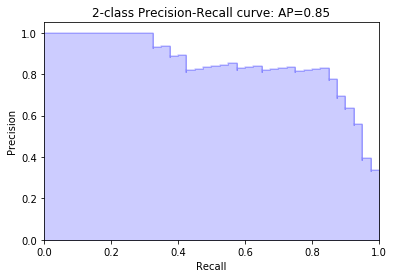

In [95]:
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


average_precision = average_precision_score(y_test, y_pred_probs)

print('Average precision-recall score RF: {}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


## Logistic Regression

In [96]:
final_pipeline_lr = Pipeline([('preprocessor', preprocessor), 
                    # ('smote', sm),
                    ('classifier', LogisticRegression(class_weight = 'balanced', 
                                                      penalty = 'l1', 
                                                      random_state=4242))])

In [97]:
param_grid = {'classifier__C':np.logspace(-3,2,10)}

In [98]:
grid_lr = GridSearchCV(final_pipeline_lr, param_grid, cv = cv, scoring = 'roc_auc')

grid_lr.fit(X_train, y_train)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtyp

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, fl

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtyp

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, fl

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtyp

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, fl

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Defa

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cont', Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['font-size', 'left', 'top', 'Num...penalty='l1', random_state=4242,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__C': array([1.00000e-03, 3.59381e-03, 1.29155e-02, 4.64159e-02, 1.66810e-01,
       5.99484e-01, 2.15443e+00, 7.74264e+00, 2.78256e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [100]:
print("Best Score %s" % grid_lr.best_score_)
print("Best Parameter %s" % grid_lr.best_params_)

Best Score 0.9779965267287182
Best Parameter {'classifier__C': 0.1668100537200059}


In [101]:
y_pred = grid_lr.predict(X_test)

# Merge y_pred with y_pred_with_red
y_pred = y_pred.astype(int) | pred_by_re_test.astype(int)

confusion_metrics(y_test, y_pred)
metrics(y_test, y_pred)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 2188
False Negatives: 2
True Positives: 38
False Positives: 95
 
Other Metrics:
 
Precision 0.29
Recall / True Positive Rate 0.95
True Negative Rate: 0.96
Accuracy score: 0.96
F1 score: 0.44
ROC AUC score: 0.95


In [102]:
for i in np.arange(0.5,1,0.01):
    y_pred = grid_lr.predict_proba(X_test)[:, 1] > i
    print("")
    print("Metrics")
    print("Threshold =", i)
    print("")
    print(metrics(y_test, y_pred))
    print(confusion_metrics(y_test, y_pred))

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.5

Accuracy score: 0.96
F1 score: 0.43
ROC AUC score: 0.94
None
True Negatives: 2188
False Negatives: 3
True Positives: 37
False Positives: 95
 
Other Metrics:
 
Precision 0.28
Recall / True Positive Rate 0.93
True Negative Rate: 0.96
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.51

Accuracy score: 0.96
F1 score: 0.43
ROC AUC score: 0.94
None
True Negatives: 2189
False Negatives: 3
True Positives: 37
False Positives: 94
 
Other Metrics:
 
Precision 0.28
Recall / True Positive Rate 0.93
True Negative Rate: 0.96
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.52

Accuracy score: 0.96
F1 score: 0.44
ROC AUC score: 0.94
None
True Negatives: 2192
False Negatives: 3
True Positives: 37
False Positives: 91
 
Other Metrics:
 
Precision 0.29
Recall / True Positive Rate 0.93
True Negative Rate: 0.96
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.53

Accuracy score: 0.96
F1 score: 0.45
ROC AUC score: 0.94
None
True Negatives: 2195
False Negatives: 3
True Positives: 37
False Positives: 88
 
Other Metrics:
 
Precision 0.30
Recall / True Positive Rate 0.93
True Negative Rate: 0.96
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.54

Accuracy score: 0.96
F1 score: 0.45
ROC AUC score: 0.94
None
True Negatives: 2195
False Negatives: 3
True Positives: 37
False Positives: 88
 
Other Metrics:
 
Precision 0.30
Recall / True Positive Rate 0.93
True Negative Rate: 0.96
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.55

Accuracy score: 0.96
F1 score: 0.45
ROC AUC score: 0.94
None
True Negatives: 2195
False Negatives: 3
True Positives: 37
False Positives: 88
 
Other Metrics:
 
Precision 0.30
Recall / True Positive Rate 0.93
True Negative Rate: 0.96
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.56

Accuracy score: 0.96
F1 score: 0.45
ROC AUC score: 0.94
None
True Negatives: 2196
False Negatives: 3
True Positives: 37
False Positives: 87
 
Other Metrics:
 
Precision 0.30
Recall / True Positive Rate 0.93
True Negative Rate: 0.96
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.5700000000000001

Accuracy score: 0.96
F1 score: 0.47
ROC AUC score: 0.94
None
True Negatives: 2202
False Negatives: 3
True Positives: 37
False Positives: 81
 
Other Metrics:
 
Precision 0.31
Recall / True Positive Rate 0.93
True Negative Rate: 0.96
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.5800000000000001

Accuracy score: 0.96
F1 score: 0.47
ROC AUC score: 0.95
None
True Negatives: 2204
False Negatives: 3
True Positives: 37
False Positives: 79
 
Other Metrics:
 
Precision 0.32
Recall / True Positive Rate 0.93
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.5900000000000001

Accuracy score: 0.97
F1 score: 0.49
ROC AUC score: 0.95
None
True Negatives: 2208
False Negatives: 3
True Positives: 37
False Positives: 75
 
Other Metrics:
 
Precision 0.33
Recall / True Positive Rate 0.93
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.6000000000000001

Accuracy score: 0.97
F1 score: 0.50
ROC AUC score: 0.95
None
True Negatives: 2213
False Negatives: 3
True Positives: 37
False Positives: 70
 
Other Metrics:
 
Precision 0.35
Recall / True Positive Rate 0.93
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.6100000000000001

Accuracy score: 0.97
F1 score: 0.50
ROC AUC score: 0.95
None
True Negatives: 2213
False Negatives: 3
True Positives: 37
False Positives: 70
 
Other Metrics:
 
Precision 0.35
Recall / True Positive Rate 0.93
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.6200000000000001

Accuracy score: 0.97
F1 score: 0.49
ROC AUC score: 0.92
None
True Negatives: 2214
False Negatives: 5
True Positives: 35
False Positives: 69
 
Other Metrics:
 
Precision 0.34
Recall / True Positive Rate 0.88
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.6300000000000001

Accuracy score: 0.97
F1 score: 0.49
ROC AUC score: 0.92
None
True Negatives: 2215
False Negatives: 5
True Positives: 35
False Positives: 68
 
Other Metrics:
 
Precision 0.34
Recall / True Positive Rate 0.88
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.6400000000000001

Accuracy score: 0.97
F1 score: 0.48
ROC AUC score: 0.91
None
True Negatives: 2216
False Negatives: 6
True Positives: 34
False Positives: 67
 
Other Metrics:
 
Precision 0.34
Recall / True Positive Rate 0.85
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.6500000000000001

Accuracy score: 0.97
F1 score: 0.49
ROC AUC score: 0.91
None
True Negatives: 2217
False Negatives: 6
True Positives: 34
False Positives: 66
 
Other Metrics:
 
Precision 0.34
Recall / True Positive Rate 0.85
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.6600000000000001

Accuracy score: 0.97
F1 score: 0.49
ROC AUC score: 0.91
None
True Negatives: 2219
False Negatives: 6
True Positives: 34
False Positives: 64
 
Other Metrics:
 
Precision 0.35
Recall / True Positive Rate 0.85
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.6700000000000002

Accuracy score: 0.97
F1 score: 0.50
ROC AUC score: 0.91
None
True Negatives: 2222
False Negatives: 6
True Positives: 34
False Positives: 61
 
Other Metrics:
 
Precision 0.36
Recall / True Positive Rate 0.85
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.6800000000000002

Accuracy score: 0.97
F1 score: 0.50
ROC AUC score: 0.91
None
True Negatives: 2222
False Negatives: 6
True Positives: 34
False Positives: 61
 
Other Metrics:
 
Precision 0.36
Recall / True Positive Rate 0.85
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.6900000000000002

Accuracy score: 0.97
F1 score: 0.50
ROC AUC score: 0.91
None
True Negatives: 2222
False Negatives: 6
True Positives: 34
False Positives: 61
 
Other Metrics:
 
Precision 0.36
Recall / True Positive Rate 0.85
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.7000000000000002

Accuracy score: 0.97
F1 score: 0.51
ROC AUC score: 0.91
None
True Negatives: 2223
False Negatives: 6
True Positives: 34
False Positives: 60
 
Other Metrics:
 
Precision 0.36
Recall / True Positive Rate 0.85
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.7100000000000002

Accuracy score: 0.97
F1 score: 0.51
ROC AUC score: 0.91
None
True Negatives: 2223
False Negatives: 6
True Positives: 34
False Positives: 60
 
Other Metrics:
 
Precision 0.36
Recall / True Positive Rate 0.85
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.7200000000000002

Accuracy score: 0.97
F1 score: 0.51
ROC AUC score: 0.91
None
True Negatives: 2224
False Negatives: 6
True Positives: 34
False Positives: 59
 
Other Metrics:
 
Precision 0.37
Recall / True Positive Rate 0.85
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.7300000000000002

Accuracy score: 0.97
F1 score: 0.52
ROC AUC score: 0.91
None
True Negatives: 2225
False Negatives: 6
True Positives: 34
False Positives: 58
 
Other Metrics:
 
Precision 0.37
Recall / True Positive Rate 0.85
True Negative Rate: 0.97
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.7400000000000002

Accuracy score: 0.97
F1 score: 0.52
ROC AUC score: 0.91
None
True Negatives: 2227
False Negatives: 6
True Positives: 34
False Positives: 56
 
Other Metrics:
 
Precision 0.38
Recall / True Positive Rate 0.85
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.7500000000000002

Accuracy score: 0.97
F1 score: 0.53
ROC AUC score: 0.91
None
True Negatives: 2228
False Negatives: 6
True Positives: 34
False Positives: 55
 
Other Metrics:
 
Precision 0.38
Recall / True Positive Rate 0.85
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.7600000000000002

Accuracy score: 0.97
F1 score: 0.54
ROC AUC score: 0.91
None
True Negatives: 2230
False Negatives: 6
True Positives: 34
False Positives: 53
 
Other Metrics:
 
Precision 0.39
Recall / True Positive Rate 0.85
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.7700000000000002

Accuracy score: 0.98
F1 score: 0.54
ROC AUC score: 0.91
None
True Negatives: 2231
False Negatives: 6
True Positives: 34
False Positives: 52
 
Other Metrics:
 
Precision 0.40
Recall / True Positive Rate 0.85
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.7800000000000002

Accuracy score: 0.98
F1 score: 0.54
ROC AUC score: 0.91
None
True Negatives: 2232
False Negatives: 6
True Positives: 34
False Positives: 51
 
Other Metrics:
 
Precision 0.40
Recall / True Positive Rate 0.85
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.7900000000000003

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.91
None
True Negatives: 2233
False Negatives: 6
True Positives: 34
False Positives: 50
 
Other Metrics:
 
Precision 0.40
Recall / True Positive Rate 0.85
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.8000000000000003

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.91
None
True Negatives: 2233
False Negatives: 6
True Positives: 34
False Positives: 50
 
Other Metrics:
 
Precision 0.40
Recall / True Positive Rate 0.85
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.8100000000000003

Accuracy score: 0.98
F1 score: 0.54
ROC AUC score: 0.90
None
True Negatives: 2233
False Negatives: 7
True Positives: 33
False Positives: 50
 
Other Metrics:
 
Precision 0.40
Recall / True Positive Rate 0.82
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.8200000000000003

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.90
None
True Negatives: 2236
False Negatives: 7
True Positives: 33
False Positives: 47
 
Other Metrics:
 
Precision 0.41
Recall / True Positive Rate 0.82
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.8300000000000003

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.90
None
True Negatives: 2237
False Negatives: 7
True Positives: 33
False Positives: 46
 
Other Metrics:
 
Precision 0.42
Recall / True Positive Rate 0.82
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.8400000000000003

Accuracy score: 0.98
F1 score: 0.56
ROC AUC score: 0.90
None
True Negatives: 2238
False Negatives: 7
True Positives: 33
False Positives: 45
 
Other Metrics:
 
Precision 0.42
Recall / True Positive Rate 0.82
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.8500000000000003

Accuracy score: 0.98
F1 score: 0.56
ROC AUC score: 0.90
None
True Negatives: 2238
False Negatives: 7
True Positives: 33
False Positives: 45
 
Other Metrics:
 
Precision 0.42
Recall / True Positive Rate 0.82
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.8600000000000003

Accuracy score: 0.98
F1 score: 0.56
ROC AUC score: 0.90
None
True Negatives: 2239
False Negatives: 7
True Positives: 33
False Positives: 44
 
Other Metrics:
 
Precision 0.43
Recall / True Positive Rate 0.82
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.8700000000000003

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.88
None
True Negatives: 2241
False Negatives: 9
True Positives: 31
False Positives: 42
 
Other Metrics:
 
Precision 0.42
Recall / True Positive Rate 0.78
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.8800000000000003

Accuracy score: 0.98
F1 score: 0.56
ROC AUC score: 0.88
None
True Negatives: 2243
False Negatives: 9
True Positives: 31
False Positives: 40
 
Other Metrics:
 
Precision 0.44
Recall / True Positive Rate 0.78
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.8900000000000003

Accuracy score: 0.98
F1 score: 0.56
ROC AUC score: 0.87
None
True Negatives: 2246
False Negatives: 10
True Positives: 30
False Positives: 37
 
Other Metrics:
 
Precision 0.45
Recall / True Positive Rate 0.75
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.9000000000000004

Accuracy score: 0.98
F1 score: 0.53
ROC AUC score: 0.83
None
True Negatives: 2248
False Negatives: 13
True Positives: 27
False Positives: 35
 
Other Metrics:
 
Precision 0.44
Recall / True Positive Rate 0.68
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.9100000000000004

Accuracy score: 0.98
F1 score: 0.53
ROC AUC score: 0.83
None
True Negatives: 2248
False Negatives: 13
True Positives: 27
False Positives: 35
 
Other Metrics:
 
Precision 0.44
Recall / True Positive Rate 0.68
True Negative Rate: 0.98
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.9200000000000004

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.83
None
True Negatives: 2251
False Negatives: 13
True Positives: 27
False Positives: 32
 
Other Metrics:
 
Precision 0.46
Recall / True Positive Rate 0.68
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.9300000000000004

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.82
None
True Negatives: 2254
False Negatives: 14
True Positives: 26
False Positives: 29
 
Other Metrics:
 
Precision 0.47
Recall / True Positive Rate 0.65
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.9400000000000004

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.82
None
True Negatives: 2255
False Negatives: 14
True Positives: 26
False Positives: 28
 
Other Metrics:
 
Precision 0.48
Recall / True Positive Rate 0.65
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.9500000000000004

Accuracy score: 0.98
F1 score: 0.50
ROC AUC score: 0.76
None
True Negatives: 2260
False Negatives: 19
True Positives: 21
False Positives: 23
 
Other Metrics:
 
Precision 0.48
Recall / True Positive Rate 0.53
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.9600000000000004

Accuracy score: 0.98
F1 score: 0.49
ROC AUC score: 0.75
None
True Negatives: 2262
False Negatives: 20
True Positives: 20
False Positives: 21
 
Other Metrics:
 
Precision 0.49
Recall / True Positive Rate 0.50
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.9700000000000004

Accuracy score: 0.98
F1 score: 0.48
ROC AUC score: 0.73
None
True Negatives: 2263
False Negatives: 21
True Positives: 19
False Positives: 20
 
Other Metrics:
 
Precision 0.49
Recall / True Positive Rate 0.47
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.9800000000000004

Accuracy score: 0.98
F1 score: 0.39
ROC AUC score: 0.67
None
True Negatives: 2266
False Negatives: 26
True Positives: 14
False Positives: 17
 
Other Metrics:
 
Precision 0.45
Recall / True Positive Rate 0.35
True Negative Rate: 0.99
None


C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.9900000000000004

Accuracy score: 0.98
F1 score: 0.28
ROC AUC score: 0.60
None
True Negatives: 2274
False Negatives: 32
True Positives: 8
False Positives: 9
 
Other Metrics:
 
Precision 0.47
Recall / True Positive Rate 0.20
True Negative Rate: 1.00
None


In [103]:
one_hot_feature_names_lr = get_feature_names(grid_lr)

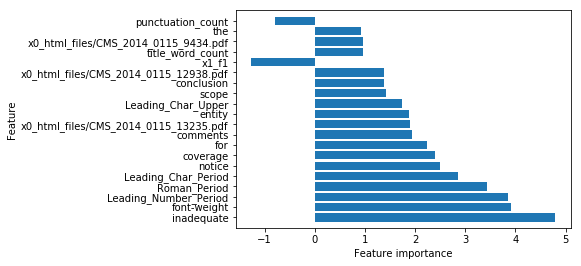

In [104]:
plot_top_k_feature_importances_pipe(one_hot_feature_names_lr, 
                                    grid_lr.best_estimator_.named_steps['classifier'].coef_[0], 
                                    20)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


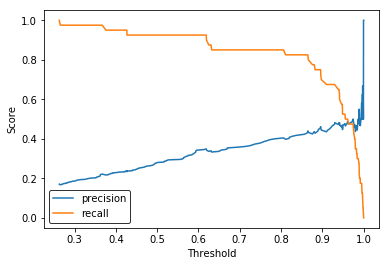

In [105]:
y_pred_probs = grid_lr.predict_proba(X_test)[:, 1]
plot_pr_curve(y_test, y_pred_probs)